<a href="https://colab.research.google.com/github/nlei1/nlp-notebooks/blob/main/reddit_finetuned_biowordvec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np, pandas as pd 
import os
import zipfile
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats
import gensim
import gensim.downloader as api
from gensim.models import Word2Vec 
import seaborn as sns
import matplotlib.pyplot as pyplot
%matplotlib inline

In [2]:
from nltk.tokenize import RegexpTokenizer

In [3]:
!wget -P /root/input/ -c 'https://ftp.ncbi.nlm.nih.gov/pub/lu/Suppl/BioSentVec/BioWordVec_PubMed_MIMICIII_d200.vec.bin'

--2022-07-11 13:40:17--  https://ftp.ncbi.nlm.nih.gov/pub/lu/Suppl/BioSentVec/BioWordVec_PubMed_MIMICIII_d200.vec.bin
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.7, 165.112.9.229, 2607:f220:41e:250::10, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.7|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [4]:
import gensim
# https://github.com/ncbi-nlp/BioSentVec
# Embeddings using PubMed and the clinical notes from MIMIC-III Clinical Database

model = gensim.models.KeyedVectors.load_word2vec_format(
     '/root/input/BioWordVec_PubMed_MIMICIII_d200.vec.bin',
      binary=True,
      limit=int(2E6)
)

In [5]:
url1 = 'https://raw.githubusercontent.com/nlei1/csvs-for-proj/main/noi.csv'
drugs = pd.read_csv(url1, error_bad_lines=False)
url2 = 'https://raw.githubusercontent.com/nlei1/csvs-for-proj/main/data.csv'
df = pd.read_csv(url2, error_bad_lines=False)
url3 = 'https://raw.githubusercontent.com/nlei1/csvs-for-proj/main/reddit_entries2.csv'
forum_posts = pd.read_csv(url3, error_bad_lines=False, names=["Message"])


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
sentences = forum_posts.Message.astype('str').tolist()
tokenizer = RegexpTokenizer(r'\w+')
sentences_tokenized = [w.lower() for w in sentences]
sentences_tokenized = [tokenizer.tokenize(i) for i in sentences_tokenized]

In [7]:
model_2 = Word2Vec(size=200, min_count=1)
model_2.build_vocab(sentences_tokenized)
total_examples = model_2.corpus_count


In [8]:
model_2.intersect_word2vec_format('/root/input/BioWordVec_PubMed_MIMICIII_d200.vec.bin', binary=True)

In [9]:
model_2.train(sentences_tokenized, total_examples=total_examples, epochs=5)

(958402, 1326265)

In [10]:
url  = 'https://raw.githubusercontent.com/nlei1/csvs-for-proj/main/drugs-side-effects3.csv'
df = pd.read_csv(url, header=None, error_bad_lines=False)
insomnia_drug_names = df[0].tolist()
ind_dct = {k: v for v, k in enumerate(insomnia_drug_names)}

def get_words(drug_name):
  return [incom for incom in df.iloc[ind_dct[drug_name]] if str(incom) != 'nan']

def get_embeddings(words_lst):
  # takes in a name and returns a lst of embeddings of drug and its related words
  embeddings = []
  for item in words_lst:
    embeddings.append(model[item])
  return embeddings

def get_pca(embeddings, n_components):
  pca = PCA(n_components)
  pca_result = pca.fit_transform(embeddings)
  post_pca = pd.DataFrame(pca_result, columns = ['x','y'])
  return post_pca

def get_tsne(embeddings, p_perplexity, p_n_iter, n_components):
  tsne = TSNE(n_components, perplexity=p_perplexity, n_iter=p_n_iter)
  tsne_result = tsne.fit_transform(embeddings)
  post_tsne = pd.DataFrame(tsne_result, columns = ['x','y'])
  return post_tsne

def plot_with_labels(drug_name, pca=True, p_perplexity=1, p_n_iter=1000, n_components=2):
  words_lst = get_words(drug_name)
  embeddings_lst = get_embeddings(words_lst)
  if pca:
    post_reduction = get_pca(embeddings_lst, n_components)
  else:
    post_reduction = get_tsne(embeddings_lst, p_perplexity, p_n_iter, n_components)
  post_reduction_annotated = post_reduction.join(pd.DataFrame(words_lst, columns=['label']))
  title_str = drug_name + (": PCA" if pca else ": TSNE")
  ax = post_reduction_annotated.plot(x='x',y='y',kind='scatter',figsize=(10,10), title=title_str)
  post_reduction_annotated[['x','y','label']].apply(lambda x: ax.text(*x),axis=1)

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def plot_insomnia_drugs():
  for drug in insomnia_drug_names:
    plot_with_labels(drug)
    plot_with_labels(drug, False)

def get_similarity_table(n=20):
  result_lst = []
  for drug in insomnia_drug_names:
    result_lst.append(pd.DataFrame(model.most_similar(positive=[drug], topn=n), columns=['name (' + drug + ")", 'similarity (' + drug + ")"]))
  return pd.concat(result_lst, axis=1, join="inner")

def get_effects_table(n=20):
  result_lst = []
  for drug in insomnia_drug_names:
    result_lst.append(pd.DataFrame(model.most_similar(positive=[drug, 'effects'], negative=['medication'], topn=n), columns=['name (' + drug + ")", 'similarity (' + drug + ")"]))
  return pd.concat(result_lst, axis=1, join="inner")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


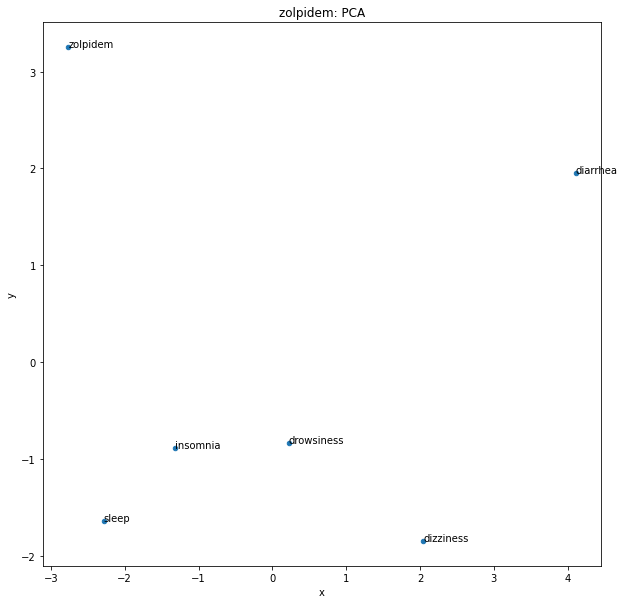

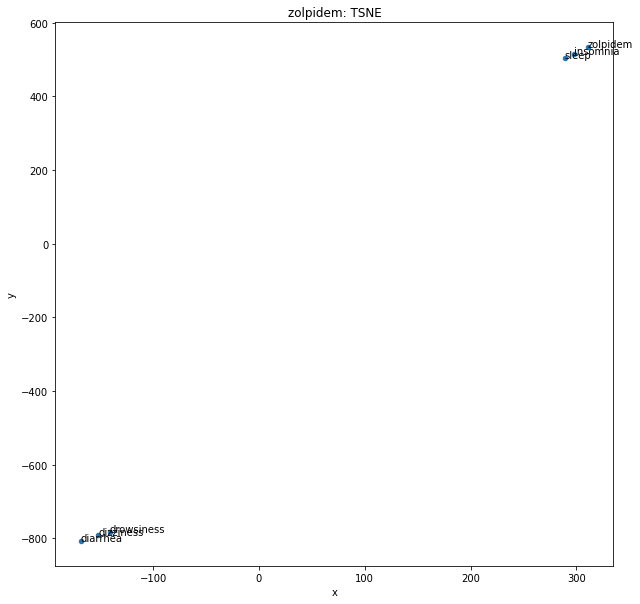

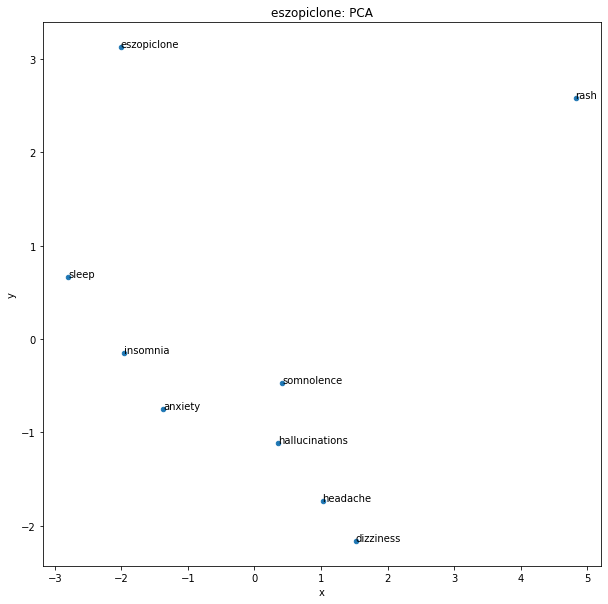

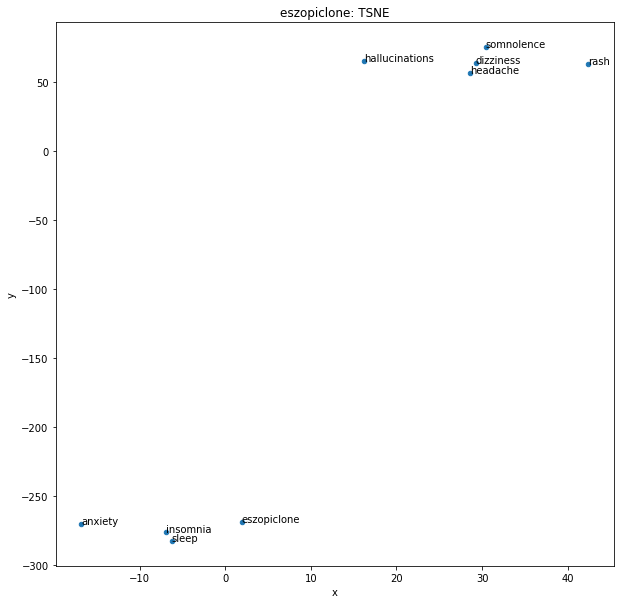

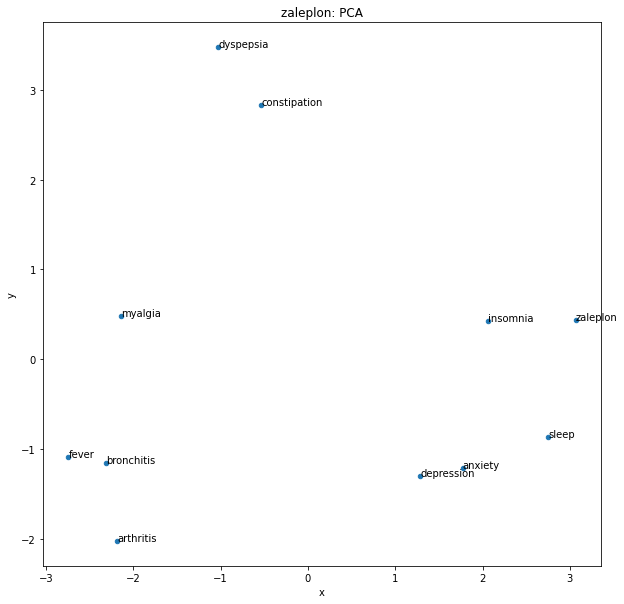

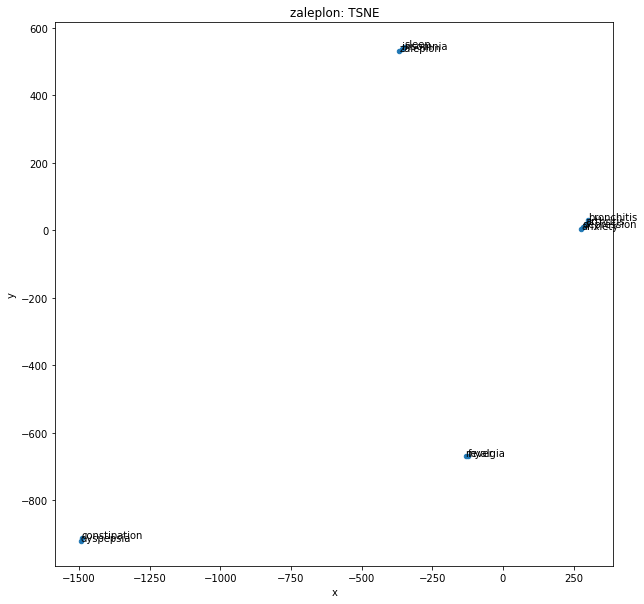

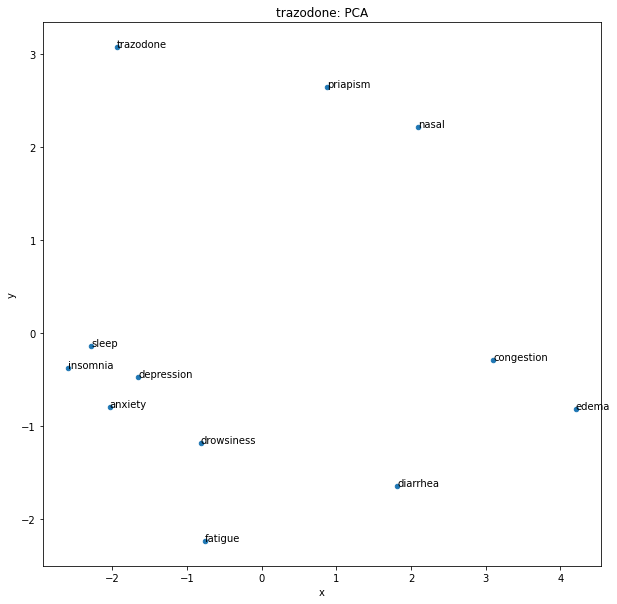

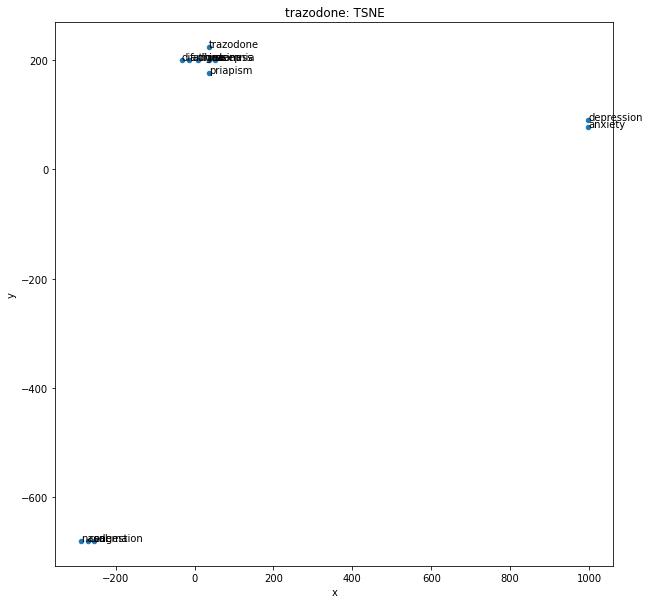

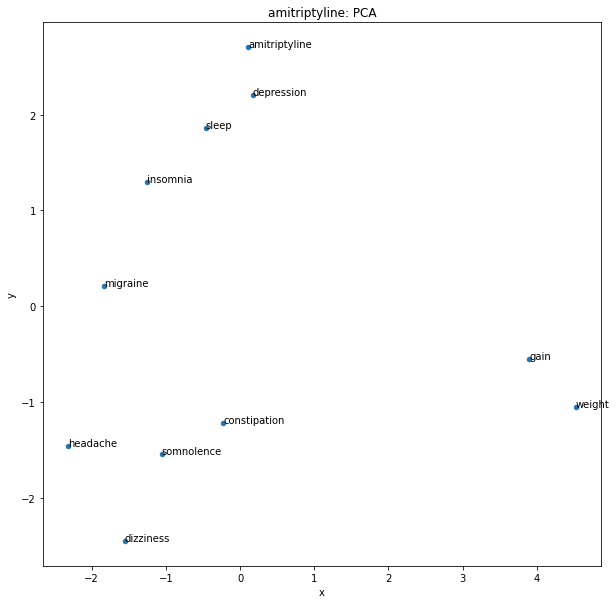

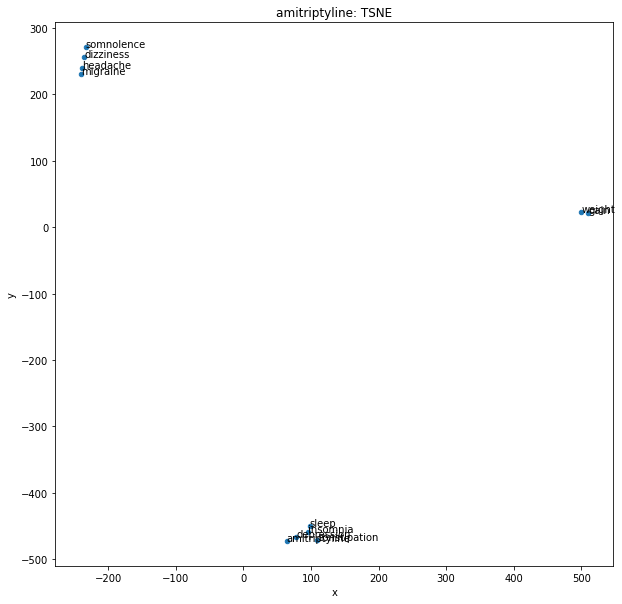

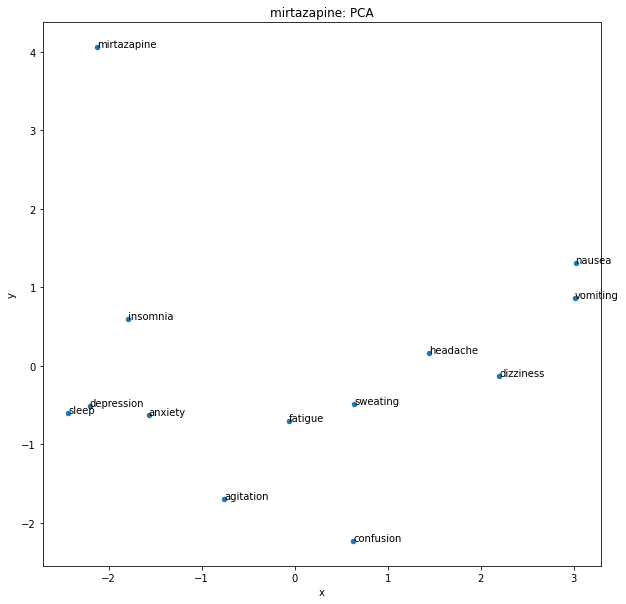

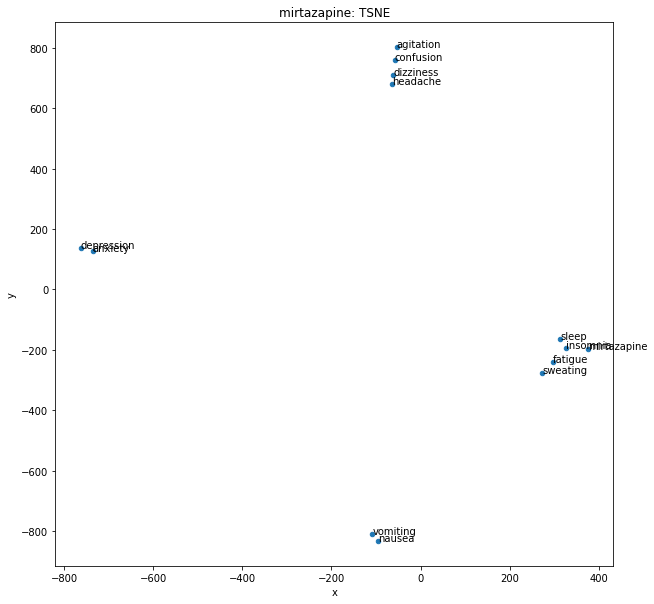

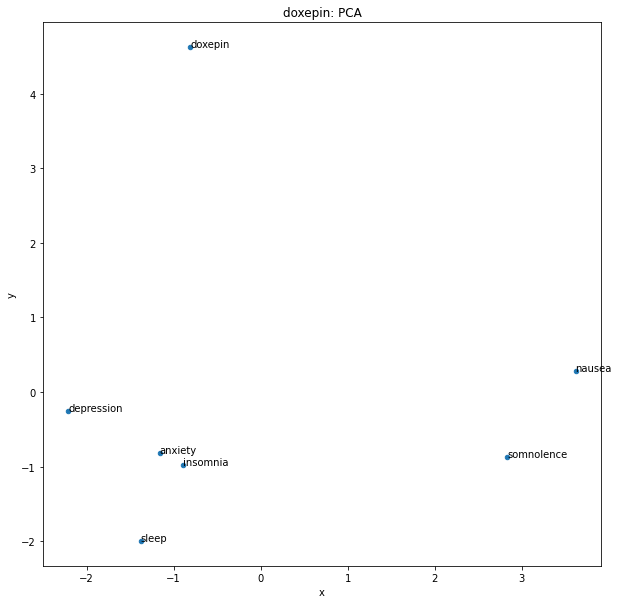

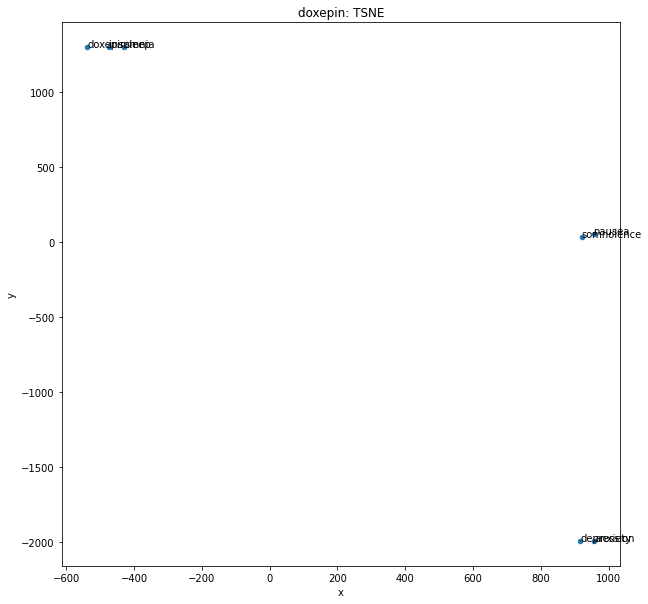

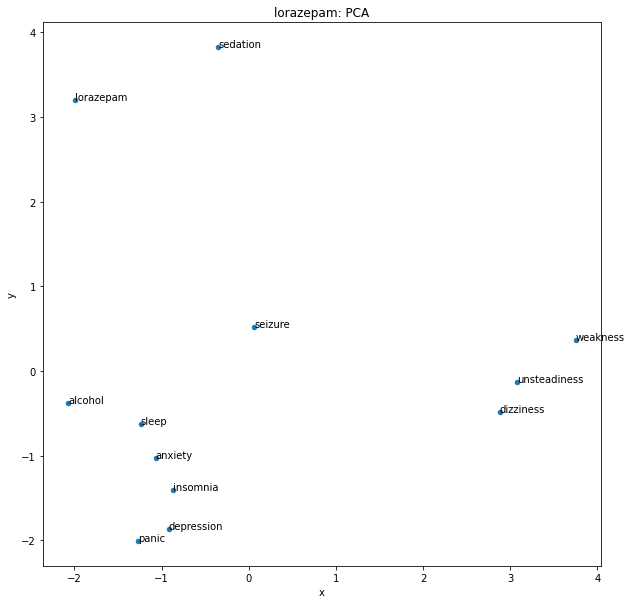

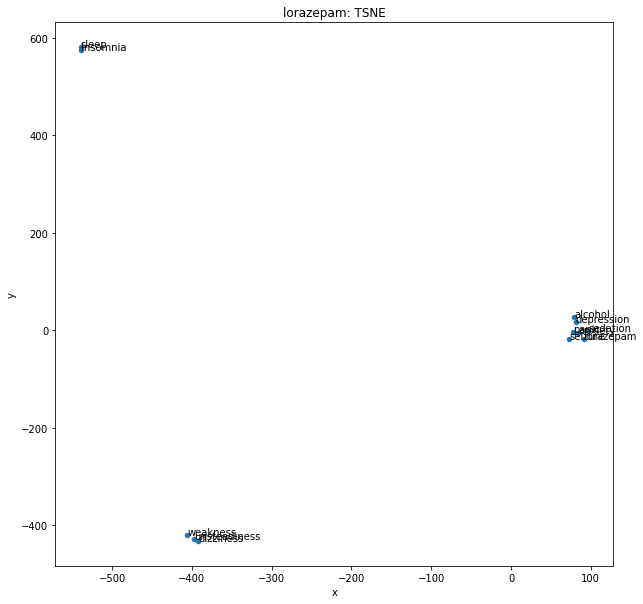

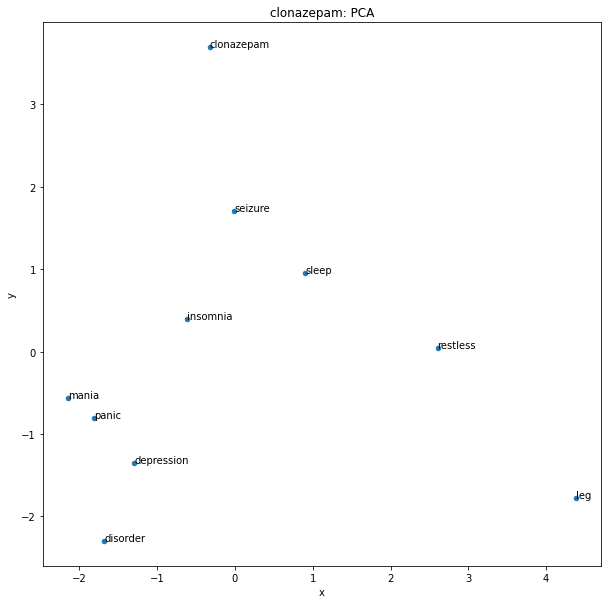

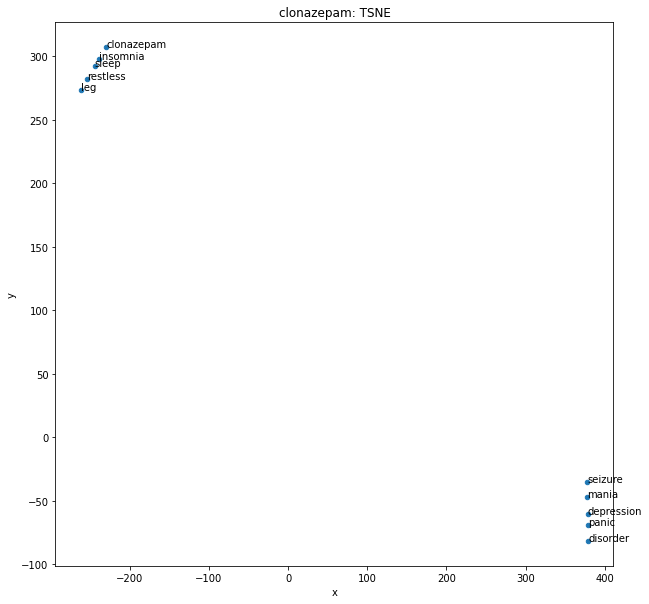

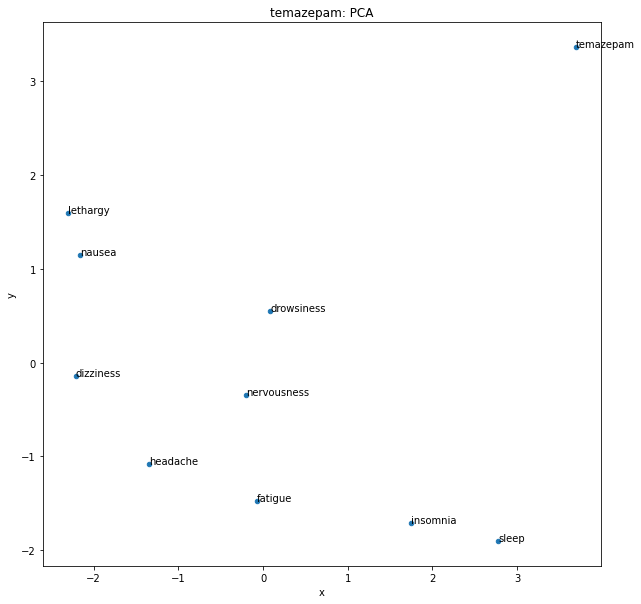

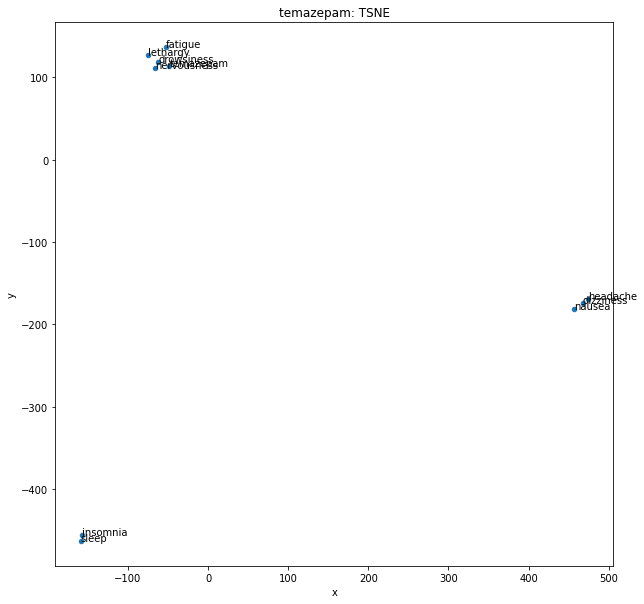

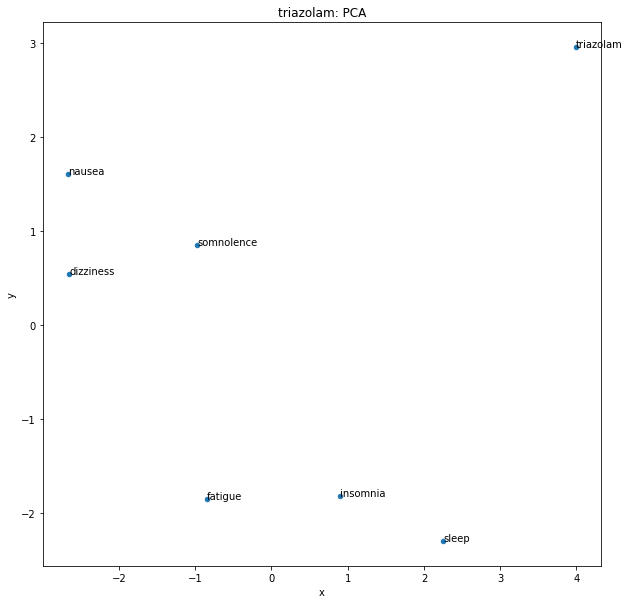

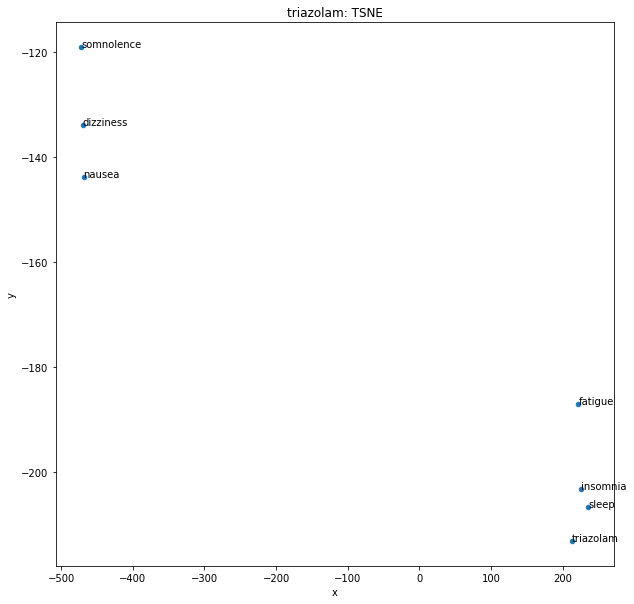

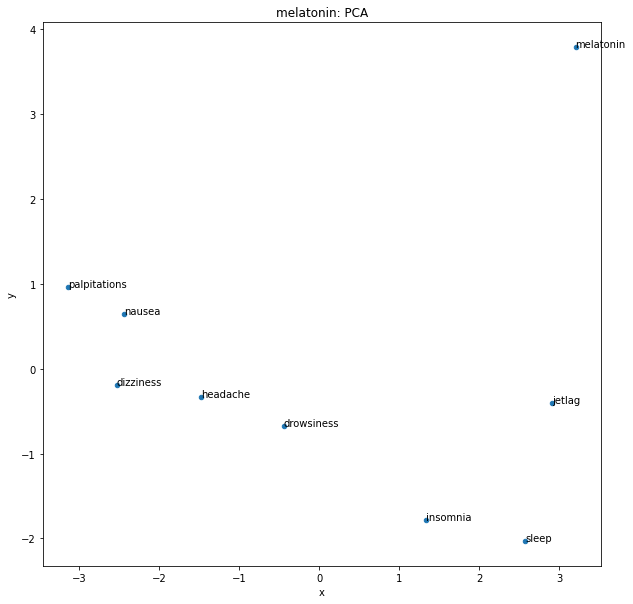

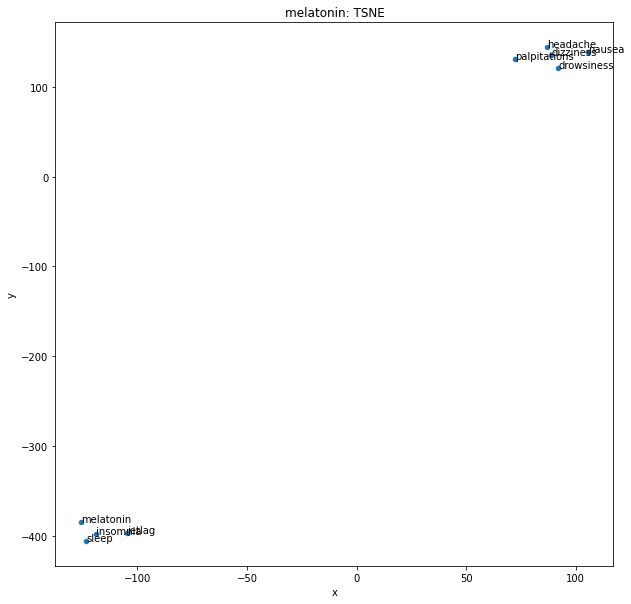

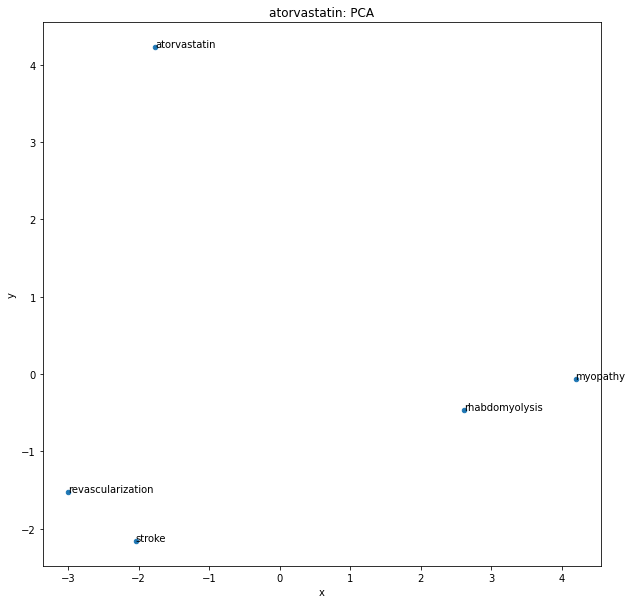

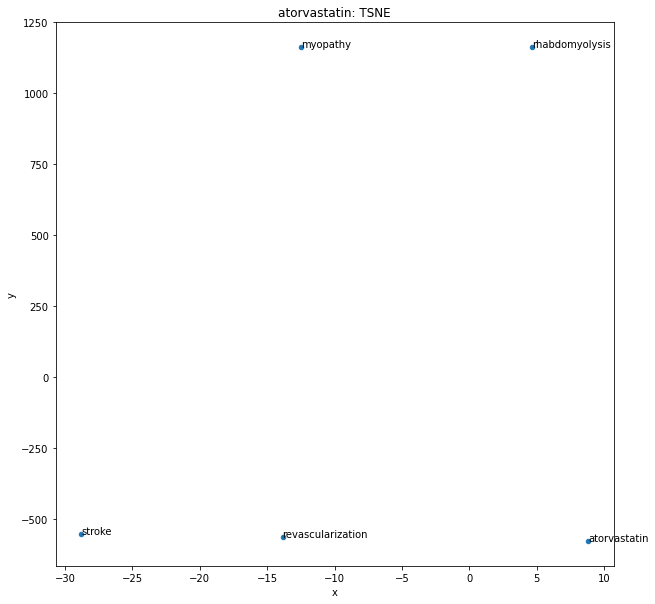

In [11]:
plot_insomnia_drugs()

In [20]:
tmp_df = get_similarity_table(1000)
from google.colab import drive

drive.mount('/content/drive')
path = '/content/drive/My Drive/reddit_finetuned_biowordvec_similarity.csv'

with open(path, 'w', encoding = 'utf-8-sig') as f:
  tmp_df.to_csv(f)




Mounted at /content/drive


In [13]:
get_effects_table()

,name (zolpidem),similarity (zolpidem),name (eszopiclone),similarity (eszopiclone),name (zaleplon),similarity (zaleplon),name (trazodone),similarity (trazodone),name (amitriptyline),similarity (amitriptyline),...,name (clonazepam),similarity (clonazepam),name (temazepam),similarity (temazepam),name (triazolam),similarity (triazolam),name (melatonin),similarity (melatonin),name (atorvastatin),similarity (atorvastatin)
0,zolpidem-induced,0.598309,2-effects,0.562770,zaleplon-induced,0.600395,trazodone's,0.611413,amitriptyline-induced,0.653893,...,chlordiazepoxide-induced,0.601985,chlordiazepoxide-induced,0.573152,triazolam's,0.628441,melatonin-induced,0.663698,atorvastatin-induced,0.652703
1,flurazepam-induced,0.580049,gaboxadol,0.562761,2-effects,0.577867,effect,0.599750,amitriptyline's,0.647353,...,effect,0.596794,beta-effects,0.559174,triazolam-induced,0.624518,melatonin's,0.659568,fluvastatin-induced,0.648590
2,flunitrazepam-induced,0.577757,effect,0.560940,zaleplone,0.572273,chlordiazepoxide-induced,0.594877,amitriptyline-evoked,0.618340,...,clonazepam-induced,0.593944,nitrazepam-induced,0.558631,2-effects,0.585415,melatonin-mediated,0.643791,atorvastatin's,0.644155
3,2-effects,0.575021,zaleplon-induced,0.549063,effect,0.548655,trazodone-induced,0.590991,effect,0.615194,...,diazepam,0.584519,diazepam,0.555995,beta-effects,0.582608,melatonin-enhanced,0.642740,rosuvastatin-induced,0.641841
4,zaleplon-induced,0.570152,ph-effects,0.541145,effects.3,0.544082,amitriptyline-induced,0.589306,amitriptylin,0.611795,...,flurazepam-induced,0.576791,oxazepam,0.555567,chlordiazepoxide-induced,0.582400,melatonin-driven,0.629193,simvastatin-induced,0.639468
5,nitrazepam-induced,0.568244,effectsof,0.536321,effectsof,0.542336,amitriptyline's,0.585783,amitriptylinoxide,0.609800,...,anticonvulsant-like,0.572436,oxazepam-induced,0.555134,effect,0.570646,melatonine,0.622296,atorvastatin-mediated,0.634672
6,alpidem,0.566256,effects.3,0.535089,beta-effects,0.537741,effects.5,0.582114,nortriptyline-induced,0.608549,...,effects.5,0.572239,nitrazepam,0.554290,concentration-effects,0.569827,melatonin-dependent,0.619156,simvastatin's,0.633657
7,chlordiazepoxide-induced,0.564695,sabeluzole,0.534909,h-effect,0.536341,fluvoxamine's,0.578494,beta-effects,0.600308,...,nitrazepam-induced,0.567377,fosazepam,0.552725,alpha-effects,0.568629,melatonin-forming,0.611205,pitavastatin-induced,0.632841
8,nefiracetam-induced,0.564092,beta-effects,0.532627,cannabinomimetic,0.535707,buspirone's,0.577412,effects.3,0.592639,...,beta-effects,0.566571,ripazepam,0.550619,flurazepam-induced,0.562952,melatonin-generating,0.598019,pravastatin-induced,0.623996
9,zolpidem's,0.563608,h-effect,0.531092,ph-effects,0.535676,sertraline's,0.574463,desipramine-induced,0.591893,...,zaleplon-induced,0.565930,effect,0.547967,nitrazepam-induced,0.561788,hormones-induced,0.592605,fluvastatin,0.620963


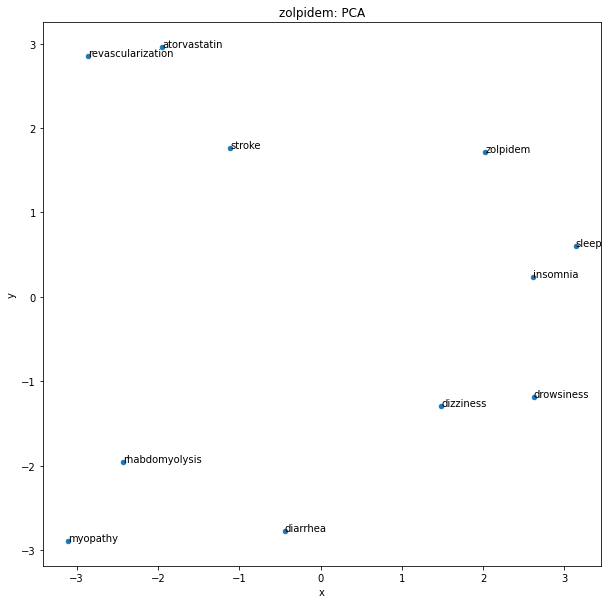

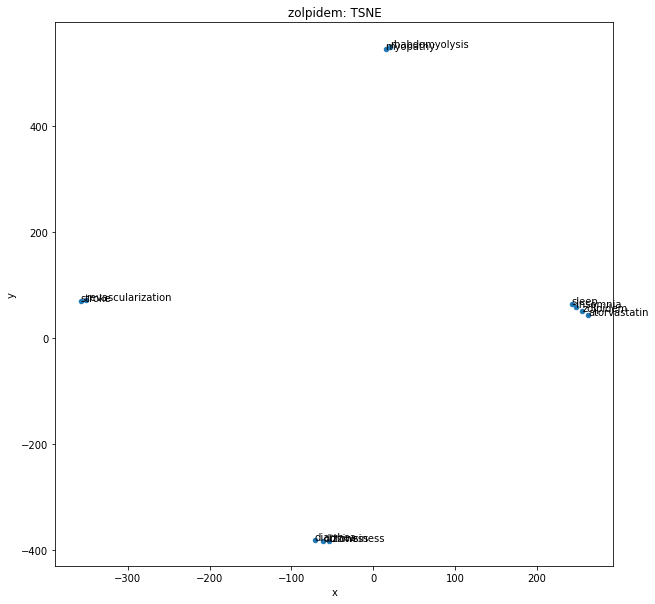

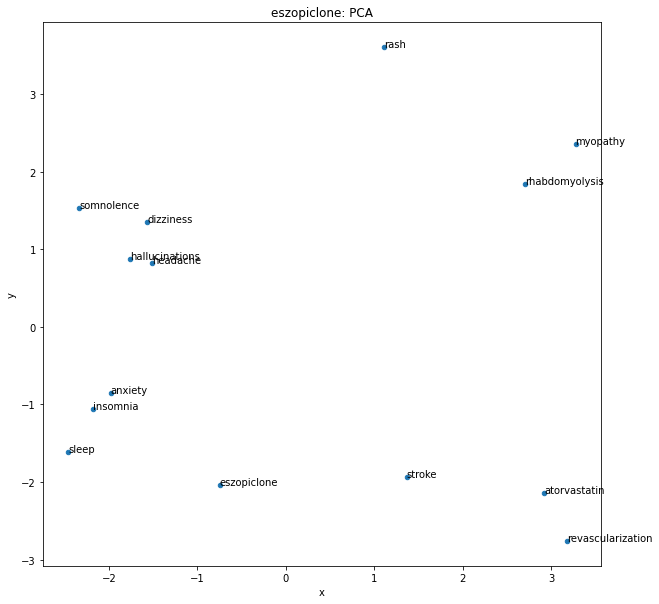

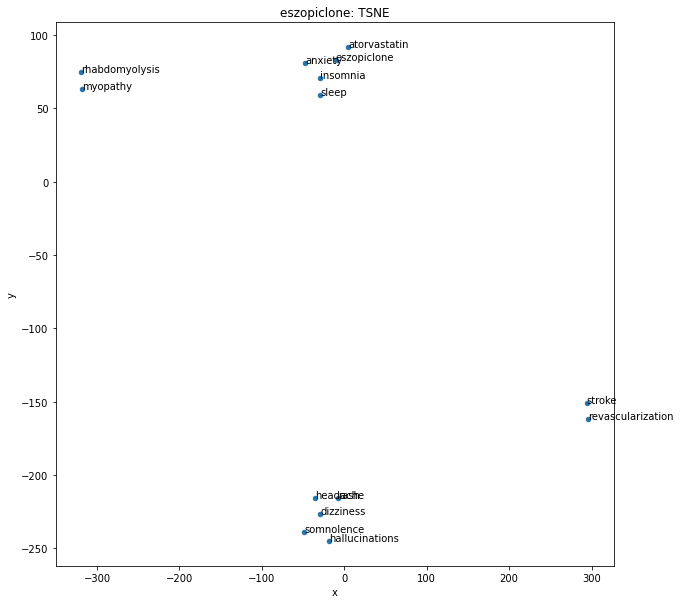

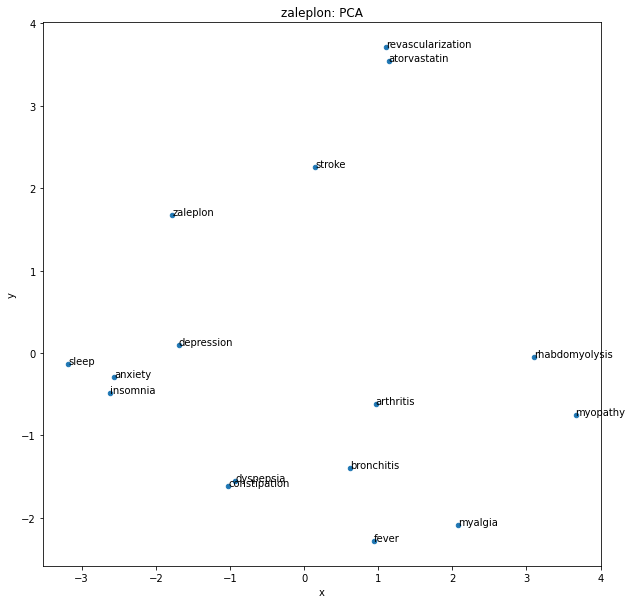

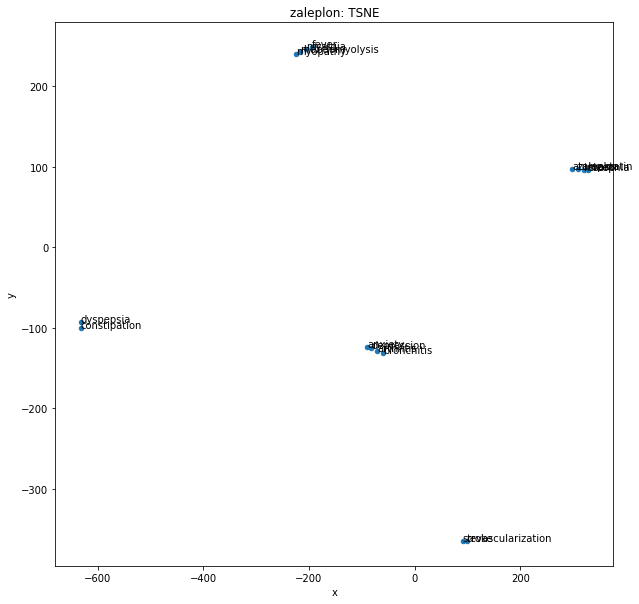

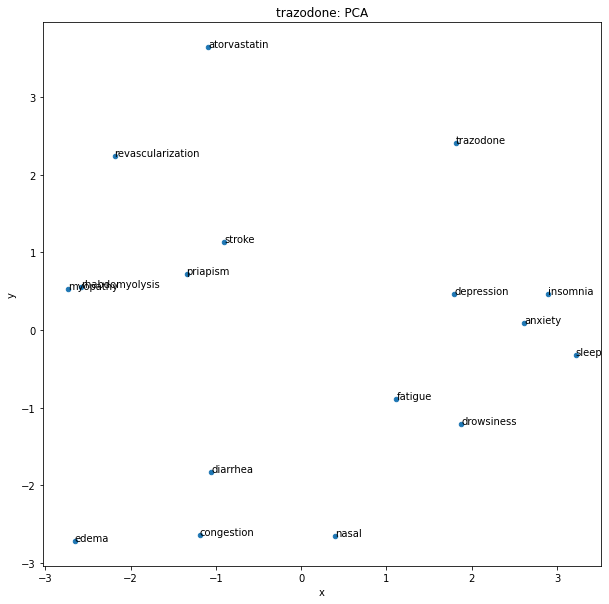

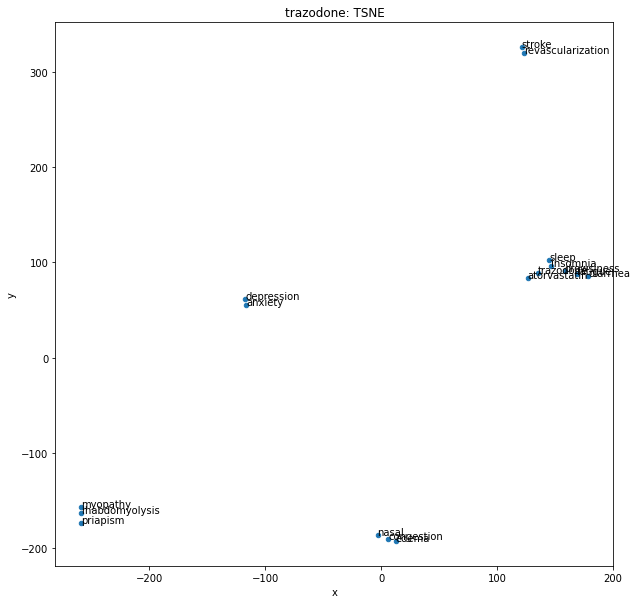

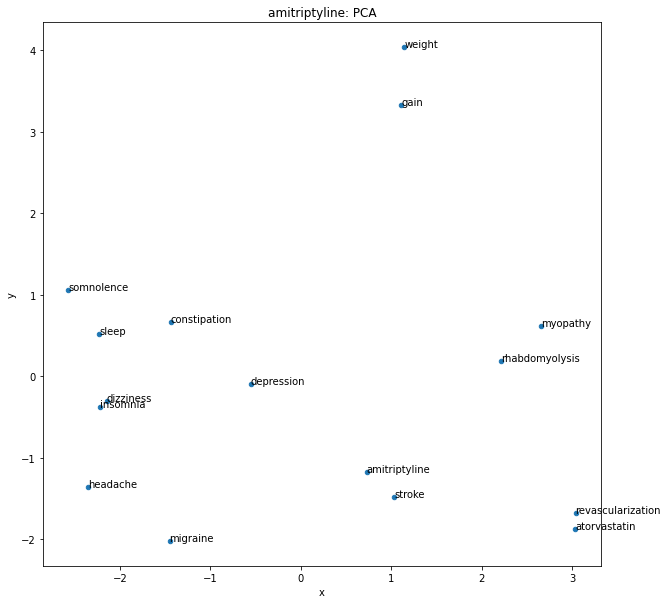

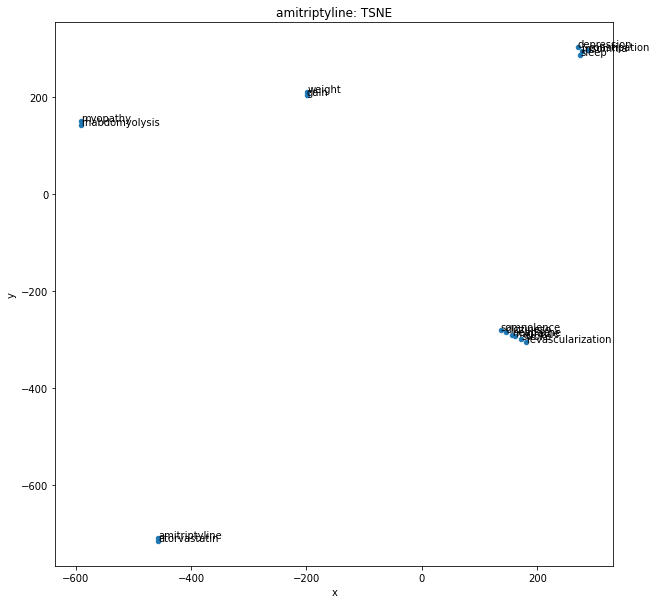

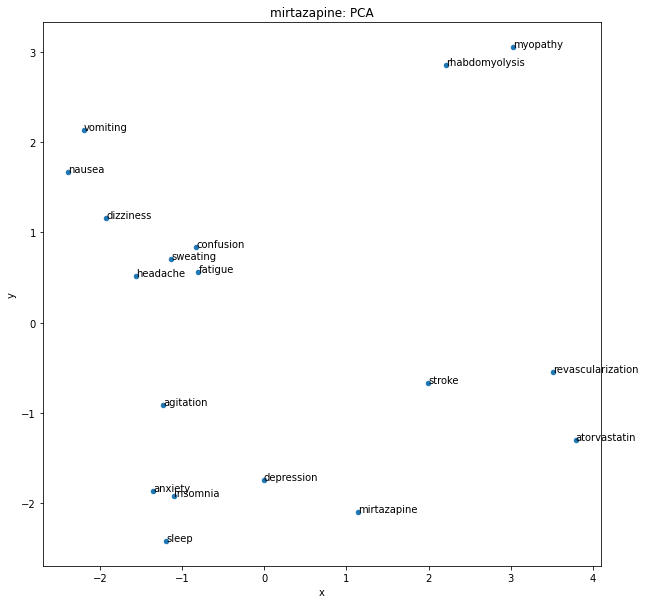

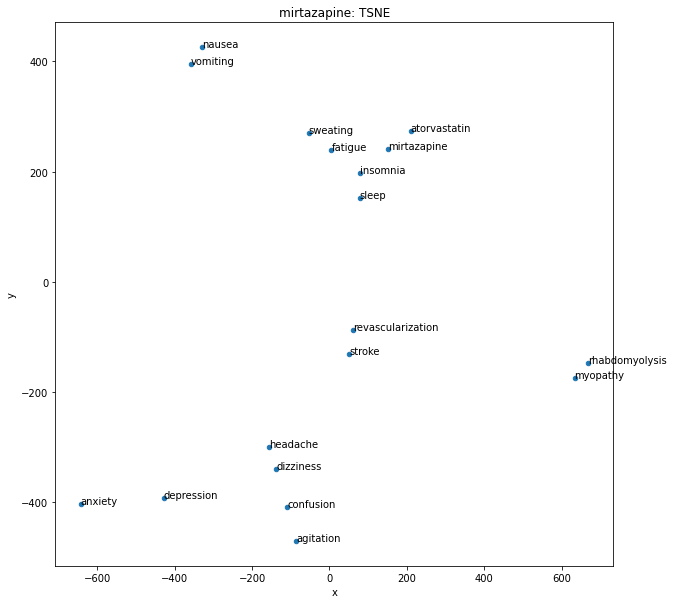

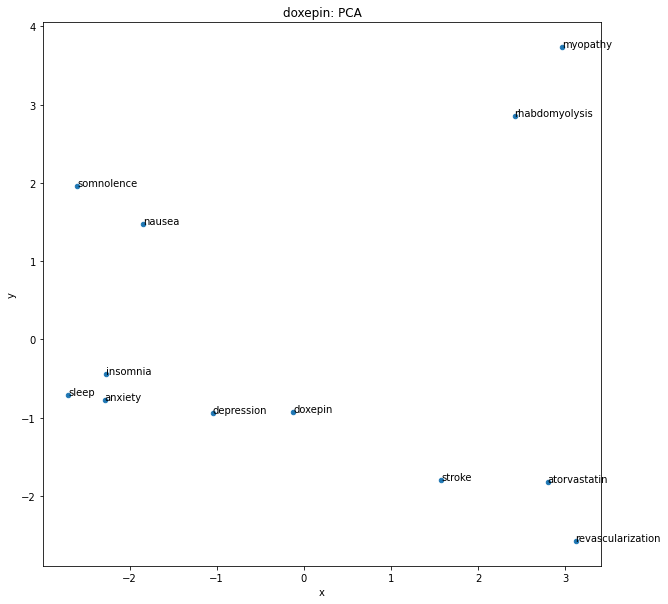

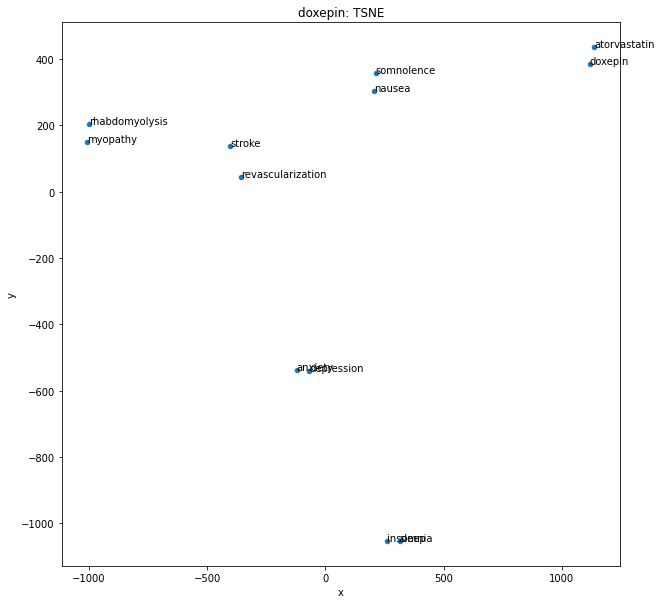

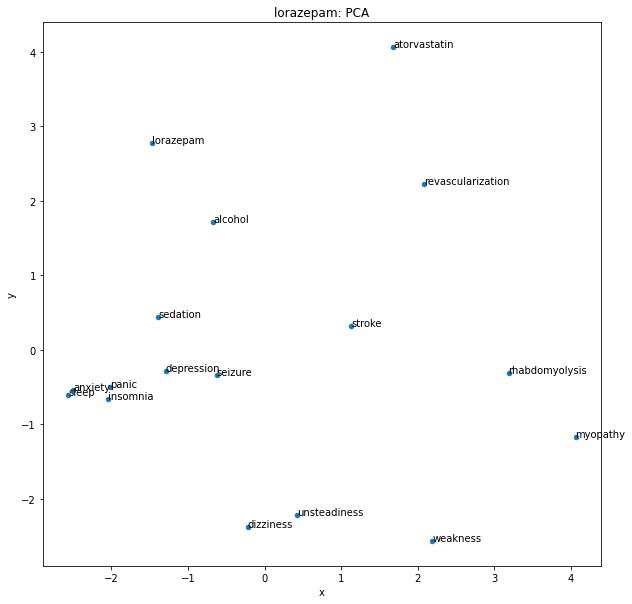

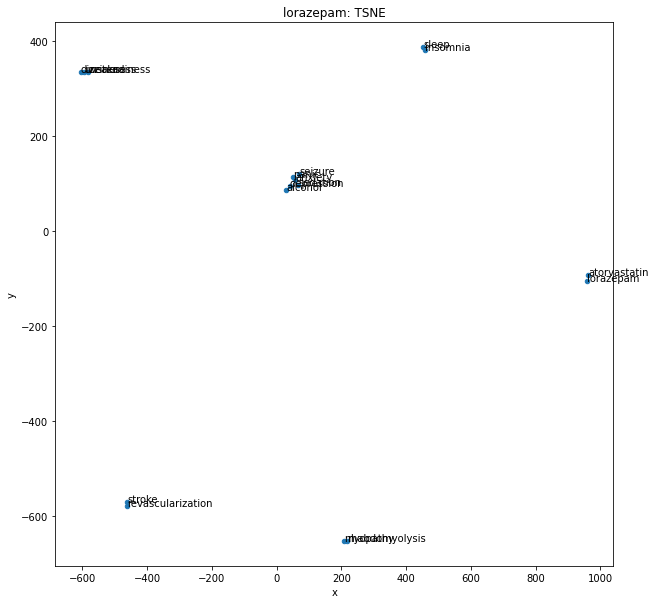

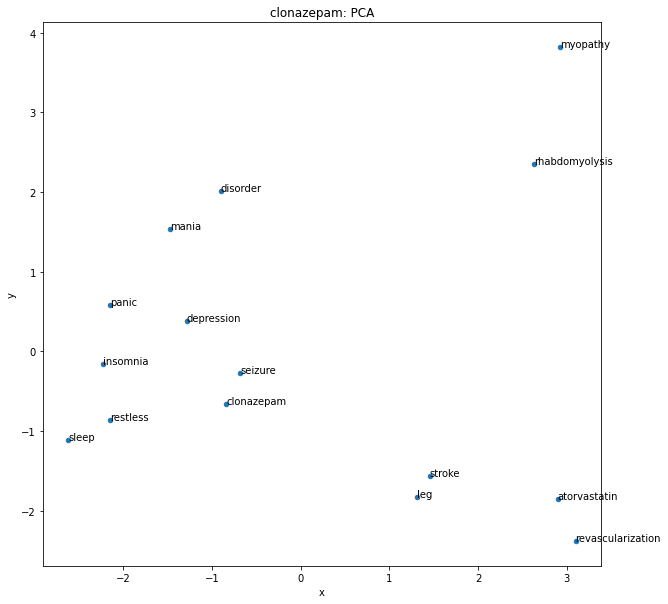

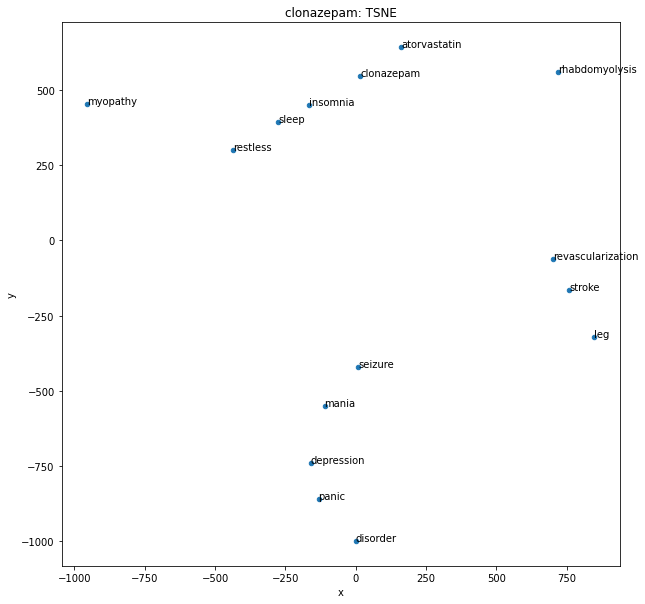

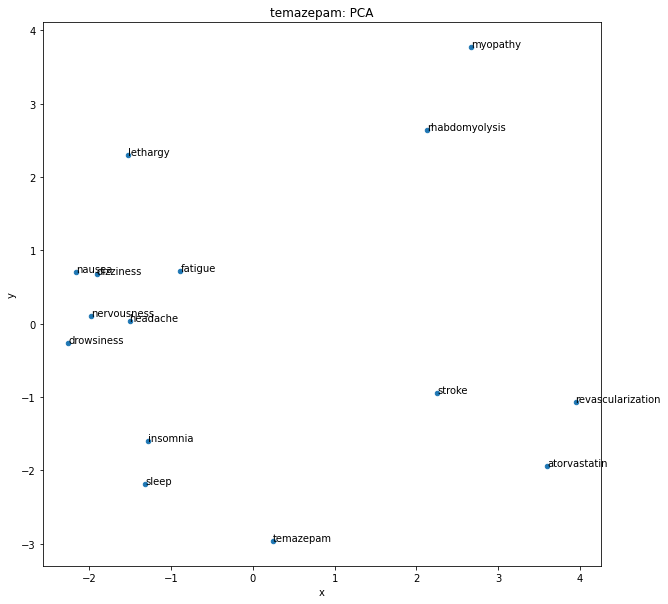

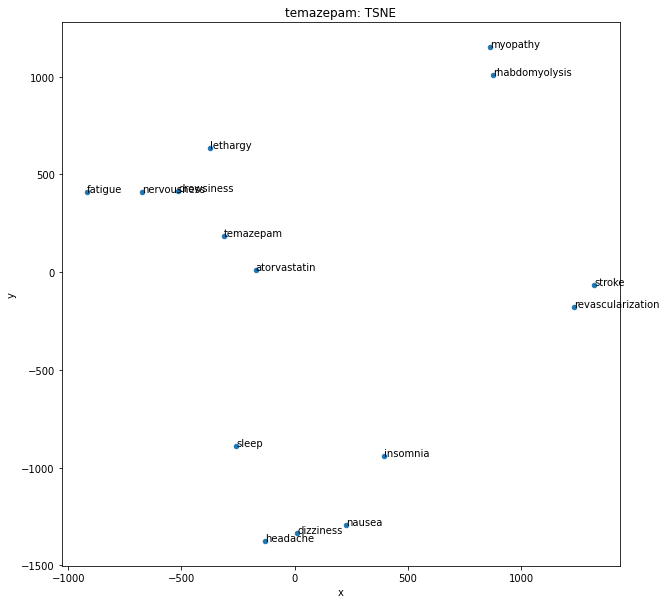

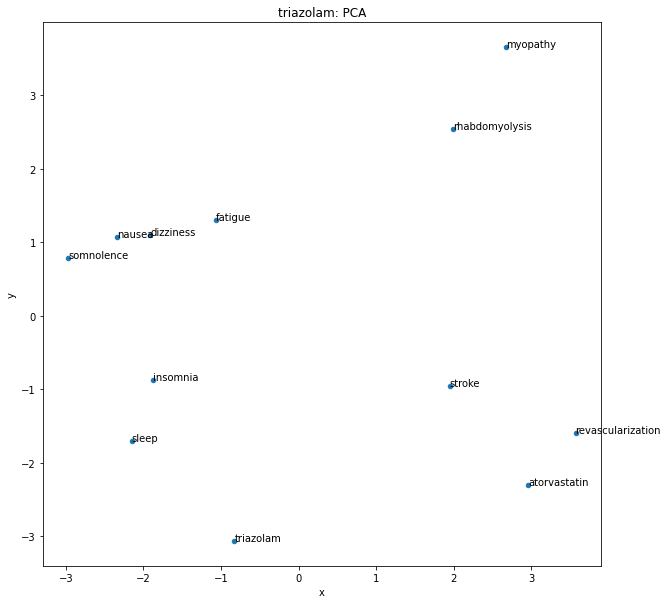

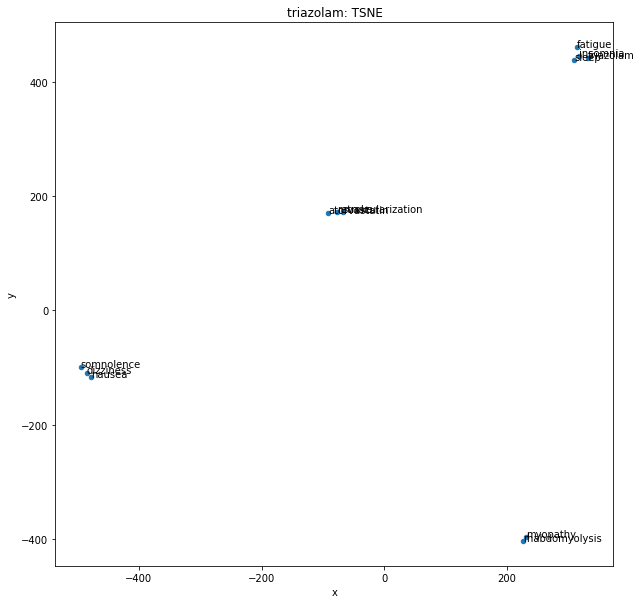

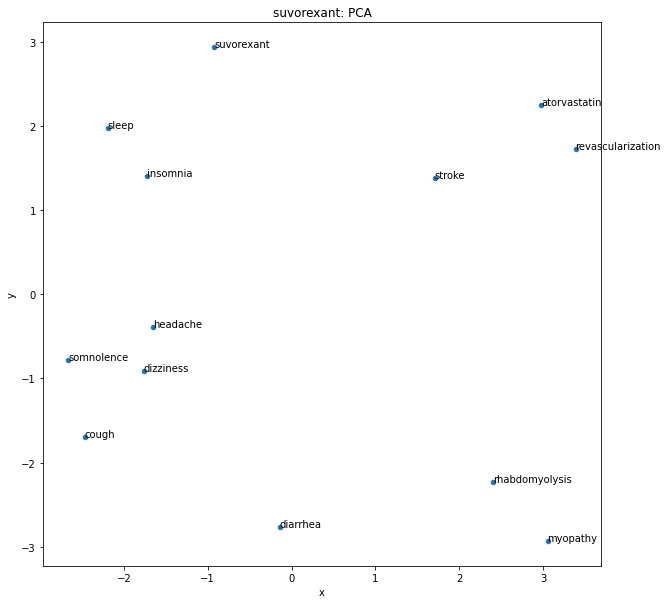

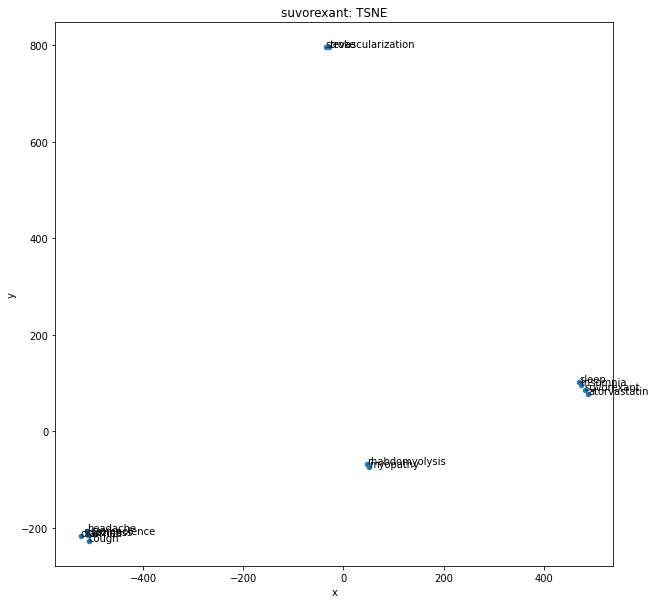

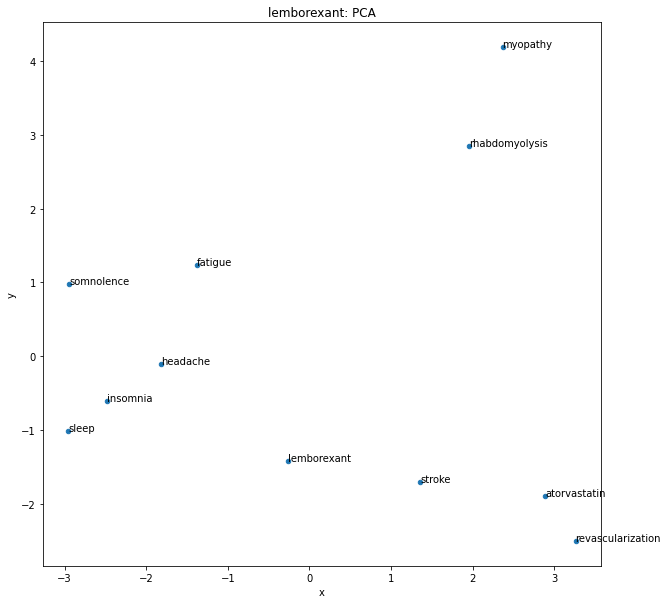

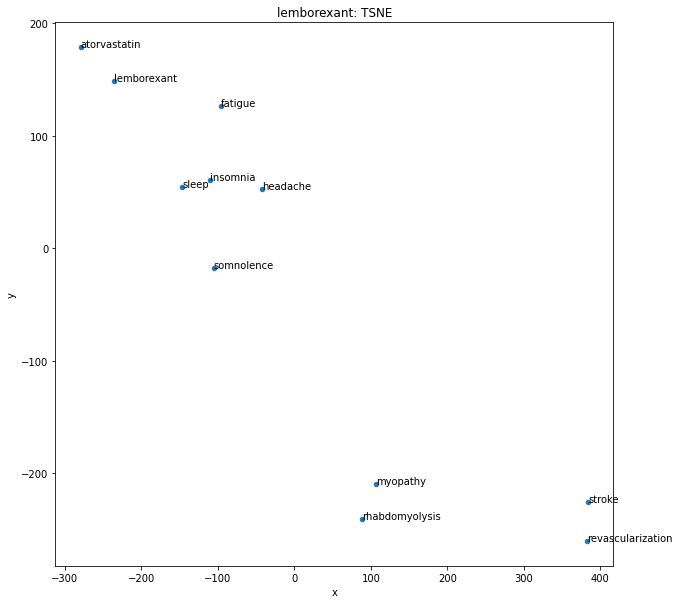

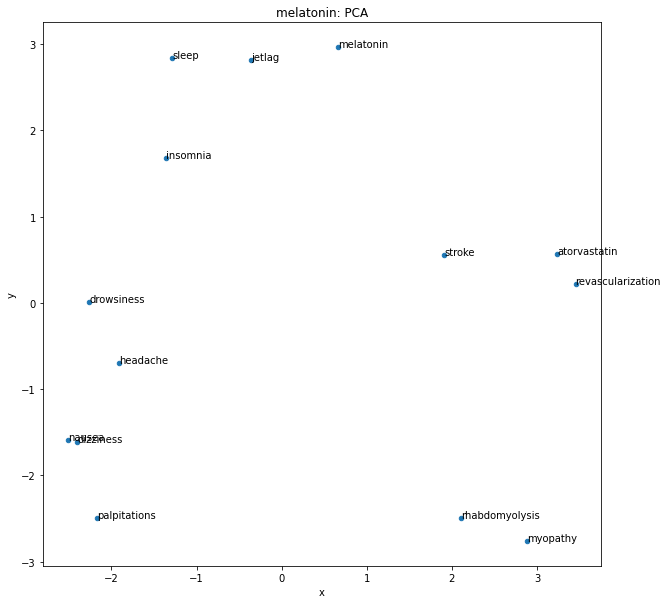

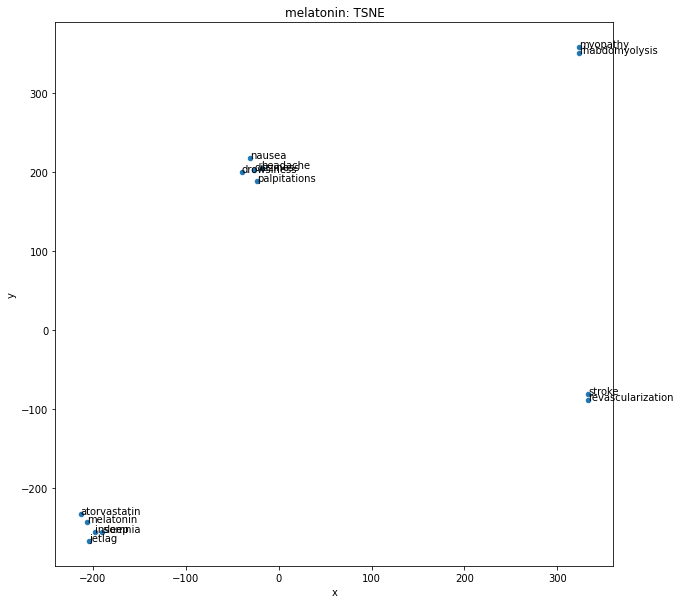

In [21]:
# sensitivity

new_url = "https://raw.githubusercontent.com/nlei1/csvs-for-proj/main/drugs-side-effects-4.csv"
new_df = pd.read_csv(new_url, header=None, error_bad_lines=False)
insomnia_drug_names2 = new_df[0].tolist()
ind_dct2 = {k: v for v, k in enumerate(insomnia_drug_names2)}

def get_words2(drug_name):
  return [incom for incom in new_df.iloc[ind_dct2[drug_name]] if str(incom) != 'nan']

def plot_with_labels2(drug_name, pca=True, p_perplexity=1, p_n_iter=1000, n_components=2):
  words_lst = get_words2(drug_name)
  embeddings_lst = get_embeddings(words_lst)
  if pca:
    post_reduction = get_pca(embeddings_lst, n_components)
  else:
    post_reduction = get_tsne(embeddings_lst, p_perplexity, p_n_iter, n_components)
  post_reduction_annotated = post_reduction.join(pd.DataFrame(words_lst, columns=['label']))
  title_str = drug_name + (": PCA" if pca else ": TSNE")
  ax = post_reduction_annotated.plot(x='x',y='y',kind='scatter',figsize=(10,10), title=title_str)
  post_reduction_annotated[['x','y','label']].apply(lambda x: ax.text(*x),axis=1)

def plot_insomnia_drugs2():
  for drug in insomnia_drug_names2:
    plot_with_labels2(drug)
    plot_with_labels2(drug, False)

plot_insomnia_drugs2()

0     Text(-2.125305599676706, -0.021582376739308094...
1     Text(-1.3618271753290463, 0.5883204736175811, ...
2     Text(-2.0427269983823653, 1.0108660645496474, ...
3     Text(-1.3895076099861319, -0.655327142414519, ...
4     Text(-0.49365997203242806, -0.4915797600830818...
5     Text(-1.0822071507006497, -0.8520175875189886,...
6     Text(-1.0107045483272832, -0.35561553362141907...
7     Text(-1.9706407126406478, -1.822172646426965, ...
8     Text(-1.8971521708116512, -0.805015388567089, ...
9     Text(-2.0384252721799427, -0.5815017141159743,...
10    Text(-2.200418059771709, 0.7998772966059886, '...
11    Text(0.08060623651156272, 4.381455669508034, '...
12    Text(3.6049490773954926, -0.8600556552468432, ...
13    Text(3.6049490773954926, -0.8600556552468432, ...
14    Text(3.513639020442423, 0.3476626083312874, 'f...
15    Text(3.289169440603401, 0.6678982389885691, 'l...
16    Text(3.519262417490187, -0.49115689162007714, ...
dtype: object

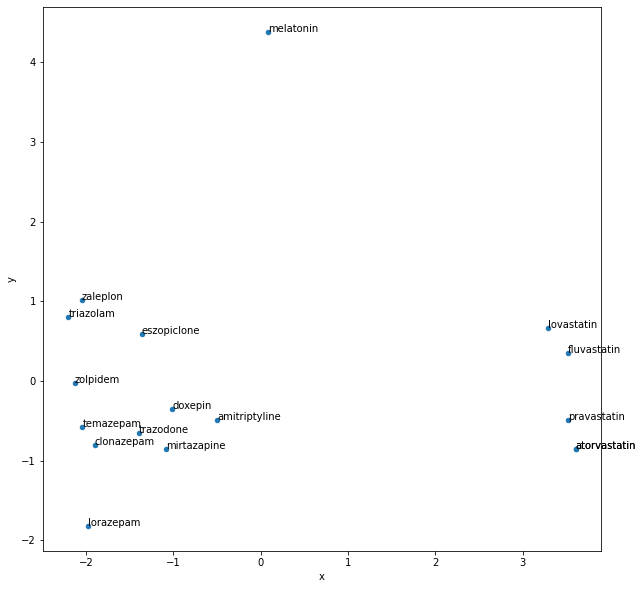

In [16]:
words_lst = df[0].tolist() + ['atorvastatin', 'fluvastatin', 'lovastatin', 'pravastatin']
embeddings_lst = get_embeddings(words_lst)
post_reduction = get_pca(embeddings_lst, n_components=2)
post_reduction_annotated = post_reduction.join(pd.DataFrame(words_lst, columns=['label']))
ax = post_reduction_annotated.plot(x='x',y='y',kind='scatter',figsize=(10,10))
post_reduction_annotated[['x','y','label']].apply(lambda x: ax.text(*x),axis=1)

0     Text(-427.98516845703125, -342.1651611328125, ...
1     Text(-227.9138946533203, 332.8241271972656, 'e...
2     Text(-412.1067810058594, -237.85621643066406, ...
3     Text(818.7392578125, 78.87403106689453, 'trazo...
4     Text(57.443294525146484, -116.15550994873047, ...
5     Text(757.392333984375, 162.41213989257812, 'mi...
6     Text(62.679386138916016, -9.934258460998535, '...
7     Text(464.6372985839844, -366.87139892578125, '...
8     Text(564.6828002929688, -335.3940124511719, 'c...
9     Text(301.28765869140625, -938.0919189453125, '...
10    Text(245.11228942871094, -1082.8028564453125, ...
11    Text(47.59712219238281, -276.8227844238281, 'm...
12    Text(-805.4271240234375, -436.32501220703125, ...
13    Text(1037.8380126953125, 397.659423828125, 'at...
14    Text(-845.3624877929688, 436.3746032714844, 'f...
15    Text(-826.408935546875, 594.8472900390625, 'lo...
16    Text(-857.621826171875, 330.51702880859375, 'p...
dtype: object

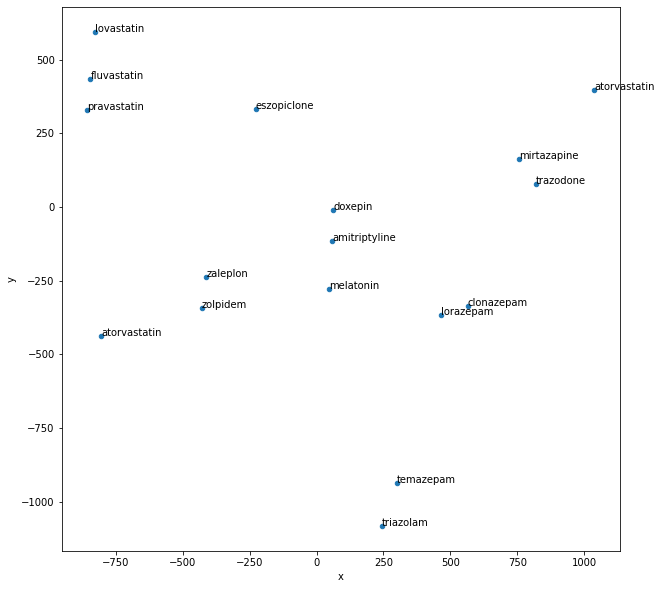

In [17]:
words_lst = df[0].tolist() + ['atorvastatin', 'fluvastatin', 'lovastatin', 'pravastatin']
embeddings_lst = get_embeddings(words_lst)
post_reduction = get_tsne(embeddings_lst, p_perplexity=1, p_n_iter=1000, n_components=2)
post_reduction_annotated = post_reduction.join(pd.DataFrame(words_lst, columns=['label']))
ax = post_reduction_annotated.plot(x='x',y='y',kind='scatter',figsize=(10,10))
post_reduction_annotated[['x','y','label']].apply(lambda x: ax.text(*x),axis=1)